# Homework 3 - Refinement of Zillow Model #

Here the goal is to go deeper by working with a data set where you have some basic sense of familiarity as a result of Homework 2<br />
<br />
The code block below achieves the following tasks:<br />
Plot matplotlib plots inline,Import all relevant libraries, suppress deparacation warning for Pandas & read the training csv's 

In [ ]:
%matplotlib inline
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn import linear_model as lm
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import permutation_test_score


from math import radians, cos, sin, asin, sqrt
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
#garbage collector
import gc
import matplotlib.pyplot as plt
from itertools import combinations
from math import radians, cos, sin, asin, sqrt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap

allFeatures2017DF = pd.read_csv("properties_2017.csv",low_memory=False)
allTargetDF = pd.read_csv("train_2017.csv")

allFeaturesDF = allFeatures2017DF
gc.collect()

This following code snippets were used from stackoverflow.These compute the distance between two coordinates on earth based on flat earth method or haversine formula.
<br>
* Computes the distance between two points:[Distance between two points](https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points)
* Computes the distance vector for a set of points:[Distance between set of two points](https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows)

</br>
These two methods were extensively used while imputation of external variables, So, It was advisable to define them at the start

In [2]:
#https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
def haversine(PointOne,PointTwo):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lat1,lon1 = PointOne
    lat2,lon2 = PointTwo
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km * 0.62137119

#https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km * 0.62137119


Here, We create a dataframe called geoDF with a feature subset relevant to geography like fips id,latitude and longitude foloowed by deleting the original frame and reclaiming the memory back by calling garbage collector

In [3]:
print(allFeaturesDF[['latitude','longitude']].isnull().sum())
geoDF=allFeaturesDF[['latitude','longitude','parcelid','fips']]
del allFeaturesDF
gc.collect()
geoDF = geoDF.drop_duplicates('parcelid')

latitude     2932
longitude    2932
dtype: int64


Fill the missing latitude and longitude with mean value(mean imputation) followed by scaling of these features to standard range i.e. Latitude to [-90,90] and longitude from [-180,180] by dividing the original data by 10^6

In [4]:
geoDF['latitude']=geoDF['latitude'].fillna(geoDF['latitude'].mean()) 
geoDF['longitude']=geoDF['longitude'].fillna(geoDF['longitude'].mean())
geoDF[['longitude','latitude']]/=1e6

In [5]:
geoDF['fips'].isnull().sum()

2932

There are a very few records with missing value for fips, this is substituted by fips of LA, as LA records for more than 90% of total records

In [6]:
geoDF['fips']=geoDF['fips'].fillna(6037)
geoDF['fips']=geoDF['fips'].astype(np.int32)

## TASK:4 External Data importing and imputation ##
<br>Here we read the external dataset obtained for CA, for details on</br>
<br>**'HOW'**: Please look for derivation of school coord csv in 'SchoolLocations.ipynb' in git</br>
**'WHERE'** :Please see attached report for the source of the data

### The School distance parameter ###

In [7]:
schoolCoord=pd.read_csv('schoolCoord.csv')

In [10]:
schoolCoord.loc[:,'fips']=0

In [11]:
schoolCoord.loc[schoolCoord['county']=='Los Angeles','fips']=6037
schoolCoord.loc[schoolCoord['county']=='Orange','fips']=6059
schoolCoord.loc[schoolCoord['county']=='Ventura','fips']=6111

Initialize the coordinates of schools to zero intially, school coord consist 15 schools for each County, total=45 schools for 3 counties.<br>
Each county dataframe has record of the coordinates of the 15 schools used below<br>
At the end of each iteration a check is performed to understand if the computed distance is lower than previous,if Yes then swap and set as minimum distance from any available school<br>
This computation is done among the two vectors in each record.

In [12]:
geoDF['C1Lat']=0.0
geoDF['C1Lon']=0.0
geoDF['distSchool']=0.0
geoDF['minDistSchool']=0.0

This step is vital, as assignment of pandas object is reference assignment and any change to original impacts the assigned variable<br>
So, a true copy of the dataframe is saved first

In [13]:
LACounty = schoolCoord.loc[schoolCoord['county']=='Los Angeles',['LAT','LNG']].copy()
VenCounty= schoolCoord.loc[schoolCoord['county']=='Orange',['LAT','LNG']].copy()
OraCounty= schoolCoord.loc[schoolCoord['county']=='Ventura',['LAT','LNG']].copy()
LACounty.reset_index(inplace=True,drop=True)
VenCounty.reset_index(inplace=True,drop=True)
OraCounty.reset_index(inplace=True,drop=True)

* Iterate through the school dataframe i.e. 15 times total for 45 schools<br>
* Compute the minimum of distance of all the records 2.98  million+ records in each iteration<br>
But, since we use the Pandas inbuild slicing functions, this runs in matter of seconds

In [14]:
for i in range(int(schoolCoord.shape[0]/3)):
    geoDF.loc[geoDF['fips']==6037 ,['C1Lat','C1Lon']]=list(LACounty.loc[i,['LAT','LNG']])
    geoDF.loc[geoDF['fips']==6059 ,['C1Lat','C1Lon']]=list(OraCounty.loc[i,['LAT','LNG']])
    geoDF.loc[geoDF['fips']==6111 ,['C1Lat','C1Lon']]=list(VenCounty.loc[i,['LAT','LNG']])
    geoDF['distSchool']=haversine_np(geoDF.latitude,geoDF.longitude,geoDF.C1Lat, geoDF.C1Lon)
    if i==0:
        geoDF['minDistSchool']=geoDF['distSchool']
    else:
        geoDF['minDistSchool'] = np.min(geoDF[['distSchool','minDistSchool']],axis=1)
#                                 = geoDF[['distC1','distC2']].min(axis=1)

drop the fields as they useless going forward and dump the file to disk<br>
This is **checkpoint** and shouldnt be skipped as this comes to aid if the system crashes at this location and it can be recovered from here

In [15]:
geoDF[['latitude','longitude','parcelid','fips','minDistSchool']].to_csv('minSchoolDistAllRecords.csv',sep=',',index=False)

Sort and Rank by minimum distance from School

In [ ]:
geoDF.sort_values(['minDistSchool'],inplace=True)
geoDF.reset_index(drop=True,inplace=True)

### The Crime location parameter ###

Read the crime coordinate locations from the crimecoord csv, preprocessing and derivation of this file is covered under 'SchoolLocations' notebook
<br>
And perform a similar operation as above to get the final crime location and the max number of crimes occured at each of the 2.98 million property records

In [16]:
crimeCoord=pd.read_csv('crimeCoord.csv')

In [17]:
crimeCoord.loc[:,'fips']=0

In [18]:
crimeCoord.loc[crimeCoord['County']=='Los Angeles County','fips']=6037
crimeCoord.loc[crimeCoord['County']=='Orange County','fips']=6059
crimeCoord.loc[crimeCoord['County']=='Ventura County','fips']=6111

In [19]:
geoDF['C1Lat']=0.0
geoDF['C1Lon']=0.0
geoDF['distCrime']=0.0
geoDF['minDistCrime']=0.0

Create dataframe with latitude,longitude and the sum of all crime at the crime location

In [20]:
try:
    del LACounty,VenCounty,OraCounty
except:
    pass
LACounty = crimeCoord.loc[crimeCoord['fips']==6037 ,['LAT','LNG','allSum']].copy()
VenCounty= crimeCoord.loc[crimeCoord['fips']==6111 ,['LAT','LNG','allSum']].copy()
OraCounty= crimeCoord.loc[crimeCoord['fips']==6059 ,['LAT','LNG','allSum']].copy()
LACounty.reset_index(inplace=True,drop=True)
VenCounty.reset_index(inplace=True,drop=True)
OraCounty.reset_index(inplace=True,drop=True)

In [21]:
geoDF['maxCrimeNum']=0

The computation is similar to how the distance from closest school was determined above,
<br>**But**, here the crime locations are not uniformly distributed **i.e.** LA county has more crime locations than ventura and Orange owing to the fact that LA is larger in area<br>
Further, once the minimum distance is computed, we fetch the maximum crime occured in that location<br>
As all the computations take the help of Pandas Slicing and indexing operation, it hardly takes more than a minute

In [ ]:
tmp=geoDF.loc[geoDF['fips']==6037]
for i in range(int(LACounty.shape[0])):
    tmp.loc[:,['C1Lat','C1Lon']]=list(LACounty.loc[i,['LAT','LNG']])
    crimeCount=LACounty.loc[i,['allSum']][0]
    tmp.loc[:,'distCrime']=haversine_np(tmp.latitude,tmp.longitude,tmp.C1Lat, tmp.C1Lon)
    if i==0:
        tmp.loc[:,'minDistCrime']=tmp.loc[:,'distCrime']
        tmp.loc[:,'maxCrimeNum']=crimeCount
    else:
        tmp.loc[:,'maxCrimeNum'].where(tmp.loc[:,'distCrime'] < tmp.loc[:,'minDistCrime'] , crimeCount,inplace=True)
        tmp.loc[:,'minDistCrime']=  np.min(tmp[['distCrime','minDistCrime']],axis=1)

In [ ]:
tmpOR=geoDF.loc[geoDF['fips']==6059 ]
for i in range(int(OraCounty.shape[0])):
    tmpOR.loc[:,['C1Lat','C1Lon']]=list(OraCounty.loc[i,['LAT','LNG']])
    crimeCount=OraCounty.loc[i,['allSum']][0]
    tmpOR.loc[:,'distCrime']=haversine_np(tmpOR.latitude,tmpOR.longitude,tmpOR.C1Lat, tmpOR.C1Lon)
    if i==0:
        tmpOR.loc[:,'minDistCrime']=tmpOR.loc[:,'distCrime']
        tmpOR.loc[:,'maxCrimeNum']=crimeCount
    else:
        tmpOR.loc[:,'maxCrimeNum'].where(tmpOR.loc[:,'distCrime'] < tmpOR.loc[:,'minDistCrime'] , crimeCount,inplace=True)
        tmpOR.loc[:,'minDistCrime']=  np.min(tmpOR[['distCrime','minDistCrime']],axis=1)

In [ ]:
tmpVE=geoDF.loc[geoDF['fips']==6111  ]
for i in range(int(VenCounty.shape[0])):
    tmpVE.loc[:,['C1Lat','C1Lon']]=list(VenCounty.loc[i,['LAT','LNG']])
    crimeCount=VenCounty.loc[i,['allSum']][0]
    tmpVE.loc[:,'distCrime']=haversine_np(tmpVE.latitude,tmpVE.longitude,tmpVE.C1Lat, tmpVE.C1Lon)
    if i==0:
        tmpVE.loc[:,'minDistCrime']=tmpVE.loc[:,'distCrime']
        tmpVE.loc[:,'maxCrimeNum']=crimeCount
    else:
        tmpVE.loc[:,'maxCrimeNum'].where(tmpVE.loc[:,'distCrime'] < tmpVE.loc[:,'minDistCrime'] , crimeCount,inplace=True)
        tmpVE.loc[:,'minDistCrime']=  np.min(tmpVE[['distCrime','minDistCrime']],axis=1)

In [25]:
CrimeDF=tmp.append(tmpOR, ignore_index=True).copy()
CrimeDF=CrimeDF.append(tmpVE, ignore_index=True).copy()

This is **checkpoint** and shouldnt be skipped as this comes to aid if the system crashes at this location and it can be recovered from here

In [27]:
CrimeDF[['parcelid','minDistCrime','maxCrimeNum']].to_csv('crimeNumAllRecords.csv',index=False)

## TASK 1:Scoring and Ranking of Property ##
We performed the scoring and ranking after the introduction of External Variable(task 4) to take the maimum advantage of the ew variable in ranking the property

The scoring function used for this purpose is:
<br>***Scoring Function(R)= InverseCrimeCount^4 + MinimumSchoolDistance^4 + BuildQuality + AreaTotal***</br>

Details of the method follows

Read the minimum distance from school and crime and the crime occurences at those locations<br>
Here, a **inner join** is performed on the **percelid** which is unique for each record,

In [29]:
schoolDistDF= pd.read_csv('minSchoolDistAllRecords.csv')
allFeaturesDF = pd.read_csv("properties_2017.csv",low_memory=False)
propWithSchoolDistDF = pd.merge(schoolDistDF, allFeaturesDF, how='inner', on='parcelid')

In [30]:
CrimeDF=pd.read_csv('crimeNumAllRecords.csv')

In [31]:
propWithSchoolAndCrimeDF=pd.merge(propWithSchoolDistDF, CrimeDF, how='inner', on='parcelid')

Check the number of records with building quality id as Null

In [32]:
propWithSchoolAndCrimeDF['buildingqualitytypeid'].isnull().sum()

1043822

In [33]:
propWithFtForRankDF=propWithSchoolAndCrimeDF[['parcelid','minDistSchool','yearbuilt','minDistCrime','maxCrimeNum',
                                             'calculatedfinishedsquarefeet','latitude_x', 'longitude_x']]

In [34]:
import warnings
warnings.filterwarnings('ignore')

<br>**Data Imputation**: Impute each column of the preoperty with mean value of the column
<br>This provides opportunity to impute each column with a different strategy

In [35]:
for column,dtype in zip(propWithFtForRankDF.columns,propWithFtForRankDF.dtypes):
    propWithFtForRankDF[column]=propWithFtForRankDF[column].fillna(propWithFtForRankDF[column].mean())

Change the year to integer data type

In [36]:
propWithFtForRankDF['yearbuilt']= propWithFtForRankDF['yearbuilt'].astype(np.int32)

Do a mean normalization for all parameters

In [37]:
schlNorm=propWithFtForRankDF['minDistSchool']
propWithFtForRankDF['schoolDistNorm']=((schlNorm-schlNorm.mean())/(schlNorm.max()-schlNorm.min()))

Use the inverse of maximum crime at nearest location as a parameter to scoring

In [38]:
crimeNorm=1/propWithFtForRankDF['maxCrimeNum']
propWithFtForRankDF['maxCrimeNorm']=((crimeNorm-crimeNorm.mean())/(crimeNorm.max()-crimeNorm.min()))

In [39]:
areaNorm=propWithFtForRankDF['calculatedfinishedsquarefeet']
propWithFtForRankDF['areaNorm']=((areaNorm-areaNorm.mean())/(areaNorm.max()-areaNorm.min()))

In [40]:
yearbuiltNorm=propWithFtForRankDF['yearbuilt']
propWithFtForRankDF['yearbuiltNorm']=((yearbuiltNorm-yearbuiltNorm.mean())/(yearbuiltNorm.max()-yearbuiltNorm.min()))

<br>***Scoring Function(R)= InverseCrimeCount^4 + MinimumSchoolDistance^4 + BuildQuality + AreaTotal***</br>
<br>Using year as inversly proportional to quality

As per our hypothesis the likeability of a property greatly depends on only one variable ***location, location and location!***<br>
So, we give maximum importance to the max crime normalized param(inverse of max crime at the property location) and minimum distance to a private school,<br>
We used normalized value of year built as a replacement for building quality(as most of the values were empty for this feature) with the assumption that property likeability depends on the building quality type , and year built is directly proportional to the quality **i.e** Older the property poorer is the quality

In [41]:
propWithFtForRankDF['Score']=propWithFtForRankDF['maxCrimeNorm']**4+propWithFtForRankDF['schoolDistNorm']**4\
                                +propWithFtForRankDF['yearbuiltNorm']+propWithFtForRankDF['areaNorm']

In [42]:
print(propWithFtForRankDF.sort_values(['Score'],ascending=False)[['parcelid','latitude_x','longitude_x','Score']].tail(10))

         parcelid  latitude_x  longitude_x     Score
1063665  11765988   33.998040  -118.275693 -0.724668
66746    12360654   33.984357  -118.225965 -0.725341
2360380  11584140   34.025236  -118.481143 -0.729929
1529439  12554225   33.781093  -118.189872 -0.732398
1894232  12560874   33.773102  -118.186552 -0.733509
1456057  12879853   34.051980  -117.738828 -0.741327
2006245  12450176   33.871931  -118.156206 -0.755386
2525733  11911158   34.095279  -118.103628 -0.756714
1392540  11911525   34.094409  -118.106565 -0.757863
1452241  11912309   34.097988  -118.106941 -0.759747


#### Verification with ground Truth ####
The rankings derived above were verified with the actual prices of the properties in the location of the top properties
the revealation was indeed interesting as most of were high priced resendential properties in Baverly Hills or around University of Southern California

There were properties commercial properties in the list belonging to other other posh locations

Write back the scoring and ranking results to disk

In [43]:
propWithFtForRankDF.to_csv('rankingResult.csv',sep=',',index=False)

In [ ]:
del propWithFtForRankDF,allFeaturesDF,CrimeDF,geoDF

## TASK 2 & 3:Clustering and Analysis ##

In this section we perform a clustering using the data we introduced in the above sections 
<br> We perform a clustering using the popular K-means algorithm where the distance function is the eucledian distance between features & is defined as:</br>

\begin{equation*}
Distance =  \sqrt(\sum_{k=1}^n (a_k-\mu_k)^2 )
\end{equation*}

Where, \begin{equation*}a_k\,\mu_k \end{equation*} are the features and respective cluster centre
<br>This can be used to determine relative closeness of two properties

In this section of the notebook, we are consuming the previously created external data and the provided features for the porpuse of clustering<br>
Inorder to understand the clustered data, data points are plotted on a geographical map(One of the primary motivation being: plotting of high dimensional clusters on a two dimensional plane by some advanced plotting methods would not be that intuitive as compared to plotting it on the geographical Map<br>
Further, an attempt was made to understand if there exists any correlation of the clusters with the **topography by plotting it on a topgraphical map**

In [2]:
allFeaturePreprocDF = pd.read_csv('properties_2017.csv', low_memory = False)

<br>
We create a set of different features that we want to pick from the training records, which have minimum number of null values(this is based on the learning from our HW 2). The features that we considered are:
* Bedroom count
* Calculated finished area of the property
* Year built
* Pool count( though this has a low valid data, we consider this as a feature for some intelligent imutation before using it)
* And Tac related features.
</br>

<br>
From the Derived dataset we use:
* Minimum Distance to Crime
* Minimum Distance to School
* Maximum Crime Count
</br>


In [3]:
numerical_features=['bathroomcnt','bedroomcnt','calculatedbathnbr','calculatedfinishedsquarefeet','fullbathcnt',\
                    'roomcnt','yearbuilt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','poolcnt']
cat_features = ['propertylandusetypeid']
parcelid=['parcelid']
coordinates=['longitude_x','latitude_x']
derived=['minDistSchool', 'minDistCrime','maxCrimeNum']

In [4]:
#these records are one time computation, comprising of ddistane of each property from the nearest
# private school in LA,Orange and Ventura
#the second records the minimum distance from the crime center and maximum occurence of crime at that location, this is consistes
#sum of all different kinds of crime
schoolDF=pd.read_csv('minSchoolDistAllRecords.csv')
crimeDF=pd.read_csv('crimeNumAllRecords.csv')

We perform a inner join of the derived dataset with the original training data

In [5]:
#perform a inner join with all records with a final record with 
# all requred feature, may consider dropping features not need(perform in place dropping)
allFeatureWSchoolDF=pd.merge(allFeaturePreprocDF, schoolDF, how='inner', on='parcelid')
allFeatureDF=pd.merge(allFeatureWSchoolDF, crimeDF, how='inner', on='parcelid')

In [ ]:
# start from here , if the notebook crashes
# allFeatureDF=pd.read_csv('allNeededFeatForClustering.csv')

Remove the original dataframes and reclaim the memory back by calling the garbag collector
(The try catch blocks are there because of the fact that we might start in the middle recovering after an error and these dataframes might not exist for deletion

In [6]:
import gc
try:
    del crimeDF,schoolDF,allFeatureWSchoolDF,allFeaturePreprocDF
except:
    pass
gc.collect()

109

**Pre-processing Block** We use the property type id for the imputation of missing values in pool count, So, We first impute the small number of missing values in porperty with the mode of the data(this is because its a discrete class variable and mean wont make much sense)

In [7]:
modeProptype=int(allFeatureDF['propertylandusetypeid'].mode().values[0])

We made an hypothesis that it makes sense to have pools only when the property belongs to certain type,They are:<br>
* 262 - Rural Residence
* 264	- Townhouse
* 265	- Cluster Home
* 266	- Condominium
* 273	- Bungalow

Proceeding with this assumption we impute all missing pool values with 1, if they belonged to any of the above property type

In [8]:
propWithPools=[262,264,265,266,273]
allFeatureDF.loc[allFeatureDF['propertylandusetypeid'].isin(propWithPools) ,['poolcnt']].fillna(1,inplace=True)
allFeatureDF.loc[:,'poolcnt'].fillna(0,inplace=True)
allFeatureDF.loc[:,'propertylandusetypeid'].fillna(modeProptype,inplace=True)

Changing the data type from the default float 64 format to appropriate format, like class variable can be ints not floats

In [9]:
#because categories should be some number (class) not floating
for col in cat_features:
    allFeatureDF[col]=allFeatureDF[col].astype(np.int32)

#set all rest to mean
for col in (numerical_features+cat_features+coordinates+derived):
    allFeatureDF.loc[:,col].fillna(allFeatureDF[col].mean(),inplace=True)

**One Hot Encoding**: Create binary variables for the property type variable for further analysis

In [10]:
propUseDF=pd.get_dummies(allFeatureDF['propertylandusetypeid'])

In [11]:
allFeatureDF[propUseDF.columns]=propUseDF

In [12]:
numerical_features=['calculatedfinishedsquarefeet','roomcnt','taxvaluedollarcnt','taxamount','poolcnt']
propTypeMaxVar=[261,266,279,246,269]

**Scaling**:Pre-Process data by min-max scaling

In [13]:
##Run ONCE ONLY!!!Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
allFeatureDF[derived+['calculatedfinishedsquarefeet','roomcnt','taxvaluedollarcnt','taxamount']]=\
            scaler.fit_transform(allFeatureDF[derived+['calculatedfinishedsquarefeet','roomcnt','taxvaluedollarcnt','taxamount']])

### K-Means Clustering and Silhoutte Score Analysis  ###

we explored k-means clustering on the following features,
1. Derived:minimum distance from school,crime and maximum crime at the location
2. Few of the property type formed to binary variable where the property was Single Family Residential,Condominium,Inferred Single Family Residential,Duplex (2 Units, Any Combination),Planned Unit Development: the purpose of this being they have maximum number of non-zero values, i.e. most of the properties belong to any of these categories
2. Some of the numerical features finished square feet, room count,tax value assessed and the tax amount collected for the property

***Silhoutte Score Analysis:***<p>
    Silhoutte score analysis the clusters on the basis of how similar the picked clusters are wrt to other clusters
    i.e. A silhoutte score of -1 indicates that the picked sample belongs to another cluster and a value of plus 1 
    indicates  that the sample s are not stongly related to cluster, whereas a value close to 0 indicates that the samples 
    in the  cluster are strongly related to each other and have a very low likehood of shifting to another cluster on 
    starting at another init.<\p>
    
The number of samples were reduced to 1e4 to fit the computation in the memory thereby preventing memory error on a 8gb  machine

We cluster in two steps, Once with cluster count from 2 through 12 and another from 12 through 20. This is done to prevent complete loss of data incase of system failure

In [ ]:
# try normalizing all numerical varibles that might faster things up a bit, not binary
s = []
min_clusters=2
max_clusters=12
fitModels=[]
for n_clusters in range(min_clusters,max_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=80,n_init=7, max_iter=300,n_jobs = -1)
    kmeans.fit(allFeatureDF[derived+propTypeMaxVar+numerical_features])
    fitModels.append(kmeans)
    s.append(silhouette_score(allFeatureDF[derived+propTypeMaxVar+numerical_features], kmeans.labels_,sample_size=int(1e4)))

The number of epochs/retry inits are reduced to enhance speed with increased number of clusters

In [ ]:
min_clusters=12
max_clusters=20
for n_clusters in range(min_clusters,max_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=80,n_init=5, max_iter=300,n_jobs = -2)
    kmeans.fit(allFeatureDF[derived+propTypeMaxVar+numerical_features])
    fitModels.append(kmeans)
    s.append(silhouette_score(allFeatureDF[derived+propTypeMaxVar+numerical_features], kmeans.labels_,sample_size=int(1e4)))

Plotting of Silhoutte score with the cluster number to understand the quality of Clusters formed

Number of clusters were analysed till n_clusters = [2,20], there are two two driving factors for this analysis :
    1. Understand the silhoutte value and affinity towards the cluster
    2. Maximize the distribution and prevent skewing of data points to a single cluster

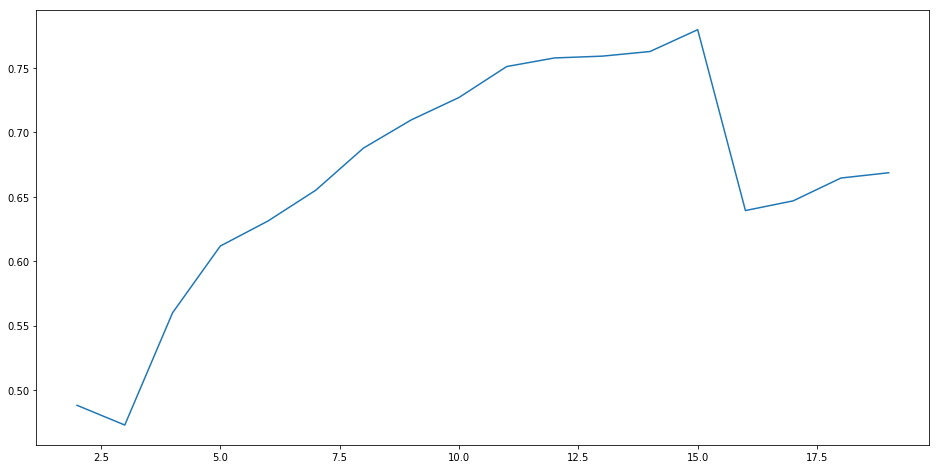

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(2,20,1),s)
plt.show()

Dumping of cluster data to disk to re-use them in case of system failure at this point

In [18]:
import pickle
pickle.dump(fitModels, open('allClusters', 'wb'))

In [ ]:
import pickle
fitModels = pickle.load(open('allClusters', 'rb'))
print('loaded')

#### Plotting of Cluster points on the map ####

Understanding the distribution by plotting on physical map of the three counties(Orange, Ventura and LA)
How the above clustering has divided the data among each Counties & How we can take advantage of the clustering

We start of by printing the number of records in each cluster for all clusters(n_clusters 2 through 20) to understand how the data is distributed

In [21]:
cCounti=0
for cCounti in range(max_clusters-2):
    cCount=cCounti+2
    allFeatureDF['ClusterLabel']=fitModels[cCounti].labels_
    countAllClusters=[ allFeatureDF.loc[allFeatureDF['ClusterLabel']==i,['ClusterLabel']].count().values[0].astype(np.int32) 
                      for i in range(cCount)]
    print(countAllClusters)
    print(cCount)

[2155795, 829422]
2
[483789, 2073888, 427540]
3
[1742562, 344209, 483789, 414657]
4
[1302716, 344209, 483789, 439846, 414657]
5
[1302716, 333147, 371697, 439846, 413245, 124566]
6
[1302716, 439846, 371697, 413248, 114415, 113301, 229994]
7
[150404, 229994, 413248, 371697, 439846, 113301, 114415, 1152312]
8
[1152312, 114415, 145105, 229993, 413248, 226592, 439846, 113302, 150404]
9
[150404, 168292, 413248, 145105, 439846, 113444, 114415, 1152312, 61559, 226592]
10
[1152312, 114415, 145105, 168290, 300583, 226592, 439846, 113442, 150404, 61559, 112669]
11
[113441, 1152312, 300582, 32214, 226592, 114415, 439846, 145105, 136089, 150404, 61559, 112658]
12
[1152312, 114415, 145105, 136089, 300582, 191024, 439846, 113441, 150404, 61559, 112658, 35568, 32214]
13
[1152312, 136086, 145105, 264870, 439846, 112092, 191024, 114415, 150404, 112658, 35568, 61559, 37064, 32214]
14
[1152312, 114651, 145105, 263556, 439846, 112092, 191024, 114415, 150404, 112658, 35568, 61559, 37045, 32214, 22768]
15
[7

Based on ditribution and symmetry,(Although Silhoutte score has a minimum value at n=3 !) we choose at n_cluster=10
As this is most evenly distributed clusters and meaningful insights can be derived from this<br>
The entire plotting extensively uses pandas slicing and basmap for mapping on geo map. Due to fact that we have used the slicing and indexing instead of iterative approach, the entire process of mapping completes within a min for all 2.98 million records

Further, the colors from matplotlibs color palette was used for this making it distinct on the map

In [22]:
cCount=10
allFeatureDF['ClusterLabel']=fitModels[cCount-2].labels_

In [23]:
allFeatureDF[['parcelid']+derived+propTypeMaxVar+numerical_features+['ClusterLabel']].to_csv('clusterWithThreecentres.csv',index=False)

plotting right MeoW!
http://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/export?bbox=38261.209684596506,-534780.3137663072,279532.83692219615,-345109.7690874478&bboxSR=3310&imageSR=3310&size=2500,1965&dpi=96&format=png32&f=image


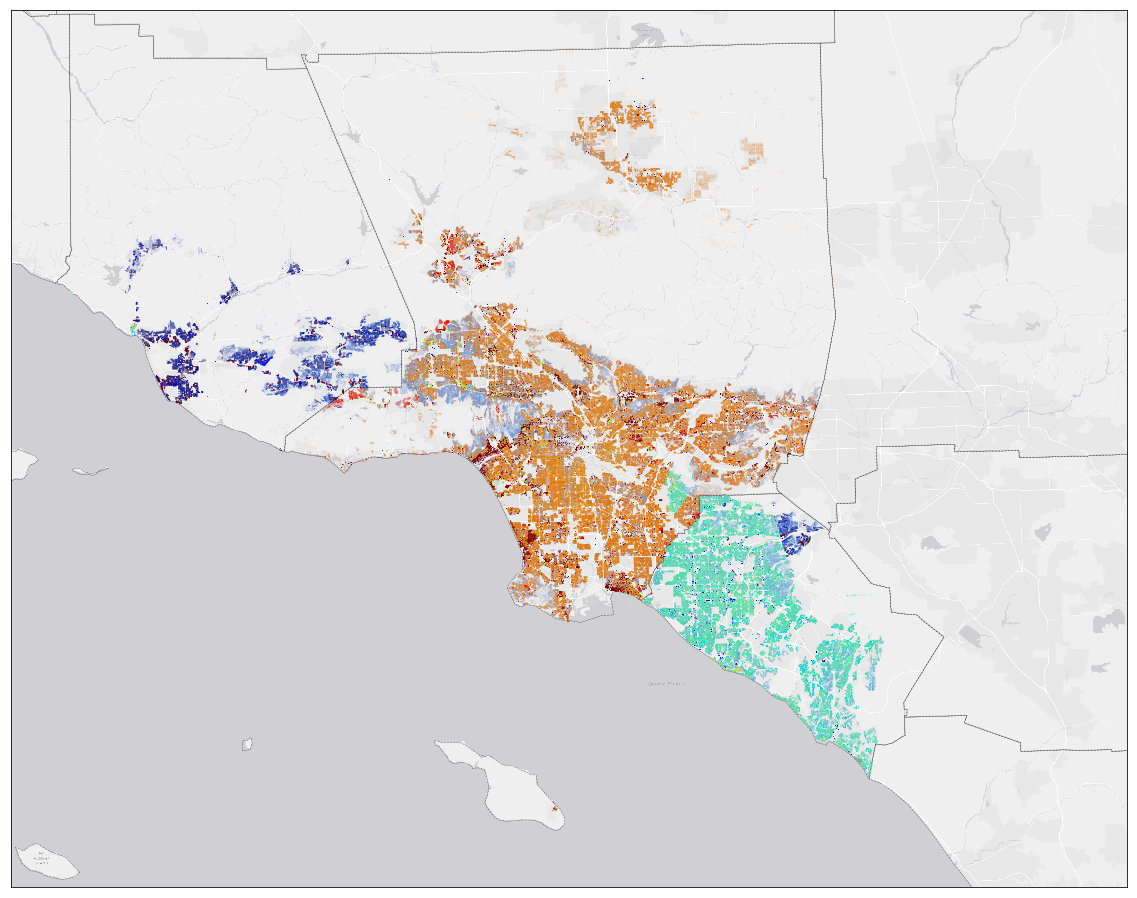

In [24]:
try:
    del map,fig,ax
except:
    pass
num_clusters=cCount

color_pallete = cm.jet(np.linspace(0,1,num_clusters))[:,:3].tolist()
fig, ax = plt.subplots(figsize=(20,18))

map = Basemap(projection='merc',resolution='h',
          lat_0=34,lon_0=-117, llcrnrlon=-119.59, llcrnrlat= 33.2, urcrnrlon=-116.94, urcrnrlat=34.87,epsg=3310)

for cCenter,clr in zip(range(num_clusters),color_pallete):
    geoClusterFltDF=allFeatureDF.loc[allFeatureDF['ClusterLabel']==cCenter,['longitude_x','latitude_x']]
    
    loc_lat = (geoClusterFltDF[["latitude_x"]]/1e6).values.astype(np.float64)
    loc_long = (geoClusterFltDF[["longitude_x"]]/1e6).values.astype(np.float64)
    x, y = map(loc_long, loc_lat)
    map.plot(x,y,marker='.',color=clr,markersize=0.02,linestyle='None')

map.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels = 2500,verbose=True) 
map.drawcounties(linewidth=0.3, linestyle='-.')
plt.show()



#### Topographic analysis ####
The intent of this analysis is to understan if there exists a latent relation between the clusters and the topography of the region i.e. we hypothised that plots near elavated regions will belong to a similar cluster

plotting right MeoW!
http://server.arcgisonline.com/ArcGIS/rest/services/World_physical_map/MapServer/export?bbox=38261.209684596506,-534780.3137663072,279532.83692219615,-345109.7690874478&bboxSR=3310&imageSR=3310&size=2500,1965&dpi=96&format=png32&f=image


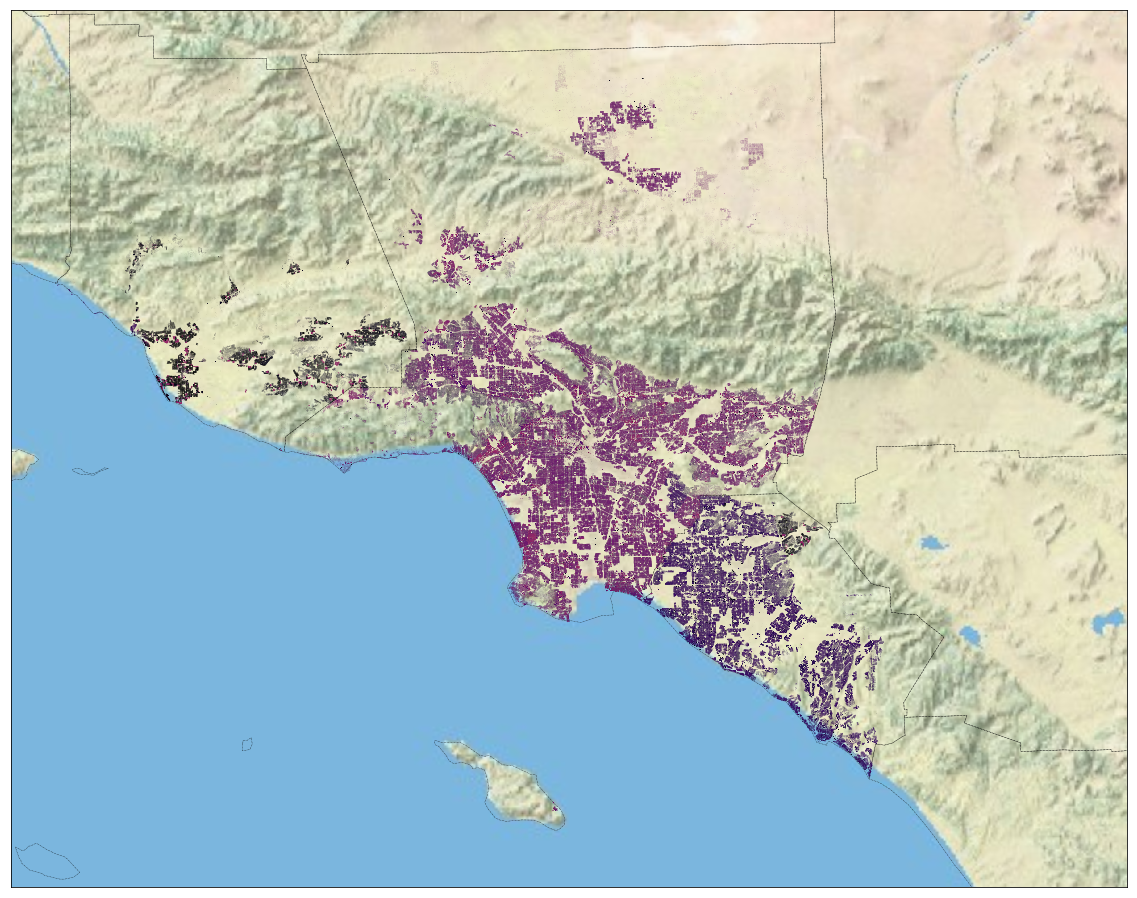

In [25]:
try:
    del map,fig,ax
except:
    pass

num_clusters=cCount

color_pallete = cm.inferno(np.linspace(0,0.4,num_clusters))[:,:3].tolist()
fig, ax = plt.subplots(figsize=(20,18))

# color_pallete=['salmon','skyblue']
#','lightsage'

map = Basemap(projection='merc',resolution='h',
          lat_0=34,lon_0=-117, llcrnrlon=-119.59, llcrnrlat= 33.2, urcrnrlon=-116.94, urcrnrlat=34.87,epsg=3310)

for cCenter,clr in zip(range(num_clusters),color_pallete):
    geoClusterFltDF=allFeatureDF.loc[allFeatureDF['ClusterLabel']==cCenter,['longitude_x','latitude_x']] 
    loc_lat = (geoClusterFltDF[["latitude_x"]]/1e6).values.astype(np.float64)
    loc_long = (geoClusterFltDF[["longitude_x"]]/1e6).values.astype(np.float64)
    x, y = map(loc_long, loc_lat)
    map.plot(x,y,marker='.',color=clr,markersize=0.02,linestyle='None')

map.arcgisimage(service='World_physical_map', xpixels = 2500,verbose=True) 
map.drawcounties(linewidth=0.3, linestyle='-.')
plt.show()



In the above map there exists a clear distinction among clusters belonging to plain regions off north east of LA county which are separated out from rest of LA

Also there is distinct red marks to the north of LA and south of Ventura which are mostly hilly areas that belonged to the same cluster

#### Analysis with cluster count 3 ####
There is a distinct separation of three counties on the basis of the cluster even though the clustering involved no parameters related to position directly

Silhoutte score has a minimum value at cluster=3

In [26]:
cCount=3
allFeatureDF['ClusterLabel']=fitModels[cCount-2].labels_

plotting right MeoW!
http://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/export?bbox=38261.209684596506,-534780.3137663072,279532.83692219615,-345109.7690874478&bboxSR=3310&imageSR=3310&size=4000,3144&dpi=96&format=png32&f=image


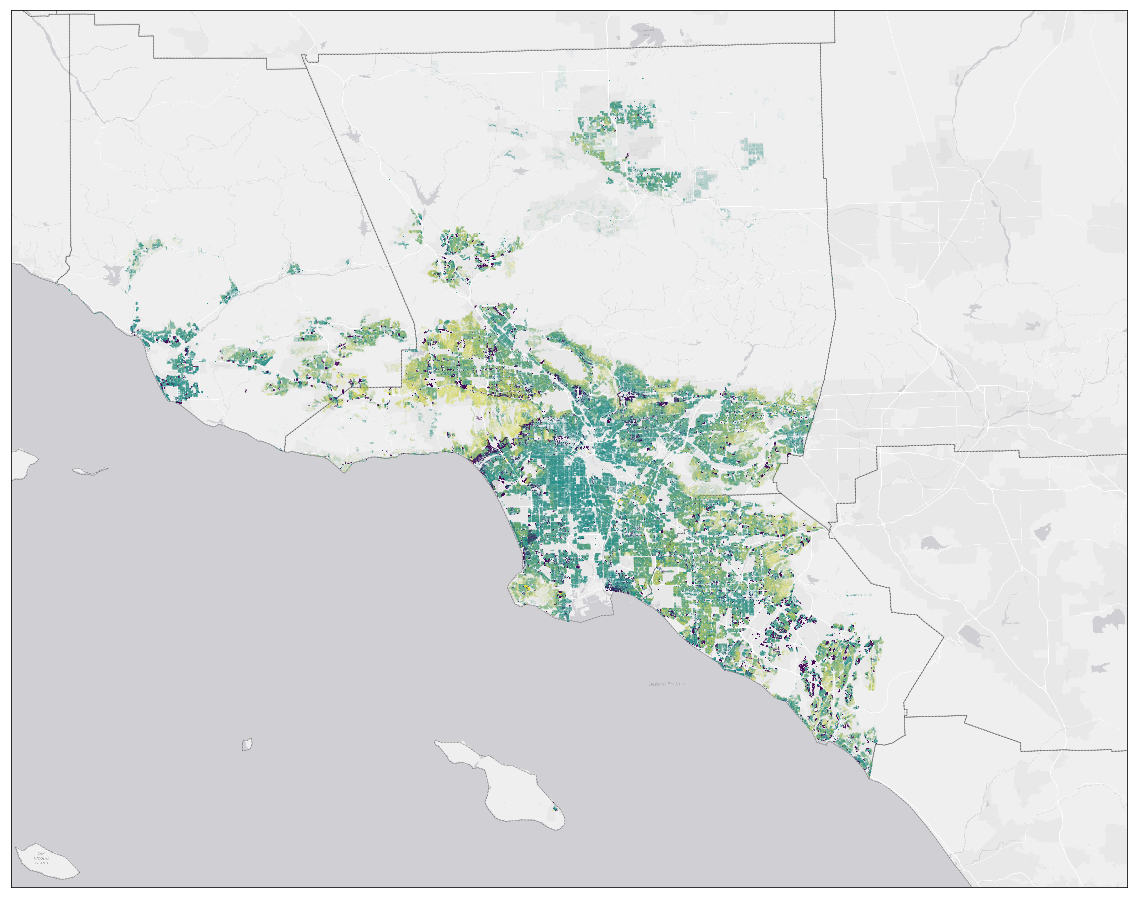

In [27]:
try:
    del map,fig,ax
except:
    pass

num_clusters=cCount

color_pallete = cm.viridis(np.linspace(0,1,num_clusters))[:,:3].tolist()
fig, ax = plt.subplots(figsize=(20,18))

# color_pallete=['salmon','skyblue']
#','lightsage'

map = Basemap(projection='merc',resolution='h',
          lat_0=34,lon_0=-117, llcrnrlon=-119.59, llcrnrlat= 33.2, urcrnrlon=-116.94, urcrnrlat=34.87,epsg=3310)

for cCenter,clr in zip(range(num_clusters),color_pallete):
    geoClusterFltDF=allFeatureDF.loc[allFeatureDF['ClusterLabel']==cCenter,['longitude_x','latitude_x']]   
    loc_lat = (geoClusterFltDF[["latitude_x"]]/1e6).values.astype(np.float64)
    loc_long = (geoClusterFltDF[["longitude_x"]]/1e6).values.astype(np.float64)
    x, y = map(loc_long, loc_lat)
    map.plot(x,y,marker='.',color=clr,markersize=0.02,linestyle='None')

map.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels = 4000,verbose=True) 
map.drawcounties(linewidth=0.3, linestyle='-.')
plt.show()







Here there are 3 distinct clusters based on non positional properties,
the clusters painted in yellow are mostly spread outward from the central location of the city, signifying larger and expensive properties??

whereas the clusters with green mostly belong to the central location of LA or closer to coast by the both sides of the road as seen in the map(zooming in the map shows the roads in plain white)

There are stints of purple at different locations of the map, looking at the even distribution across three counties, perhaps they are large property sizes

## TASK 5&7:Modelling & Predicting ###

In this section of notebook we try to evaluate the performance improvement upon addition of the new external variables,<br>
The steps followed are:
    1. Read training and testing notebook
    2. Read clustering csv, this comprised of cluster label and the three extra parameters fetched from esternal sources
    namely, minimum school distance,minimum distancec from crime location and the maximum occurence of the crime in the nearest location
    3. The variable pool count was systematically treated for removal of NA: In this the pool count was imputed by this method->     if its Bungalow,Condominium,Rural Residence,Townhouse,Cluster Homeset the pool count was set to 1 else 0
    4. After reading the clustering csv and the properties csv (only the required columns were read from each one of them), a join was performed on 'parcelid' to obtain the record of properties along with their external variables.
    5. Following this another join was performed with the resultant dataframe obtained in the above step with the training set data resulting in a record of 92715 rows
    6. Mean Imputation, data type conversion and scaling of data was performed before modeling to achieve faster convergence 

<p>
Through this exercise we tried to evaluate if there are in gaps in the zillows property evaluation by imputing external data into our system and evaluating if there are any improvement in prediction of log error. It is evident from the mean absolute error on the validation set and zillow score that the external data we choose to impute into our system had a consistent but very minimal impact to our overall score.i.e. Our Hypothesis that zillow would have ignored facts like the distance from nearest school or nearest distance at which a crime has occured is not so valid: 
<\p>

Upon analysis, there were multiple reasons for the failure of this hypothesis
    1. Zillow would have already acounted for this
    2. There is no real impact of these parameteres on the cost of a property(which we are very skeptical about)
    3. Gross error in computation of these parameters: There were certain assumptions made while computing these parameters, 
    Ex. We considered distance from private school as more determining than distance from public schools, there were top 15 schools picked from each county, whereas LA has more population,so more number of schools should have been a better idea, the criteria for selecting best schools was based on the total number of enrollements ,which might be the best approximation in the absence of other params like average SAT score.
    
***Modeling:*** In this exercise we tried to model on a subset of the data set picked by k-fold cross validation. A total number of 200 folds were made and run in iteration, saving the best model so far to a variable . The swaping was performed on the basis of the mean absolute error on the validation set.
    
This process was repeated for records in 2016 ad 2017 to populate the rows for the submission file, the reason being that the tax values in the property set have seen a updation across all counties
    
And finally we do a permutation test to prove the genuinity of the model


In [ ]:
imputeFlag=0
imputeFlag1=0
try:
    del allFeaturesDF,allTargetDF
except:
    pass

As seen above we create feature subset list for different type of feature

In [29]:
clFtList=['minDistSchool','minDistCrime','maxCrimeNum','261','266','279','246','269','poolcnt','ClusterLabel']
targetFtList=['logerror']
subsetFtList = ['bathroomcnt','bedroomcnt','roomcnt','finishedsquarefeet12','calculatedfinishedsquarefeet',\
                'structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','latitude','yearbuilt']
taxFt=['living_area_prop','value_prop','value_ratio']

Read only the relevant features from original feature& target dataframe  & the **clustered** data csv to keep the memory footprint to minimum(Finally we use the clustering data with three cluster heads since it had the minimum Silhoutte score)

The data in this csv is arranged with cluster labels, so it can be directly taken into account while modelling and models can built around each one of them

In [30]:
allFeaturesDF = pd.read_csv("clusterWithThreecentres.csv",low_memory=False,usecols=clFtList+['parcelid'])
allTargetDF = pd.read_csv("train_2017.csv",usecols=targetFtList+['parcelid'])

In [31]:
allFeaturesOrgDF=pd.read_csv("properties_2017.csv",low_memory=False,usecols=subsetFtList+['parcelid'])

Mean imputation and min-max scaling for missing values

In [32]:
for col in allFeaturesOrgDF.columns:
    allFeaturesOrgDF[col]=allFeaturesOrgDF[col].fillna(allFeaturesOrgDF[col].mean())

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
allFeaturesOrgDF[subsetFtList]=scaler.fit_transform(allFeaturesOrgDF[subsetFtList])

In [34]:
allPropDF=pd.merge(allFeaturesDF, allFeaturesOrgDF, how='inner', on='parcelid')

In [35]:
# Convert 64 bits t 32 bit for faster calculation in predict set
print(len(allPropDF))

for c, dtype in zip(allPropDF[subsetFtList].columns, allPropDF[subsetFtList].dtypes):
     if dtype == np.float64:        
         allPropDF[c] = allPropDF[c].astype(np.float32)
     if dtype == np.int64:
         allPropDF[c] = allPropDF[c].astype(np.int32)

2985217


Perform a join on the target variable , feature variable and derived variable to get the final training x and y's

In [36]:
joinedNDF=pd.merge(allPropDF,allTargetDF, how='inner', on='parcelid')

### Extra tree Regressor with k-fold validation ###

We retain only a small subset of feature from what we originaly intended to keep , since there was no additianal imporvement contributed by the large set of features , rather it brought down the score.

Further we decided to use k-fold cross validation (with k=200 also checked til 500, but no improvement shown)to ensure we have a better model considering the fact that the number of target(y) is quite small as compared to the number of records to predict i.e. 2.9 million

Upon multiple runs and tests by uploading on kagle we realised that the idea of modelling per cluster didnt prove quite beneficial, this owes to the factor that the number of records in one cluster >>> the number of records in other two, leading to insufficient data for training the other two clusters and finally ending up in a poor prediction result for the clusters which belonged to the two woth lower number of records

**But ** we did create two individual models for year 2016 and 2017, this is because there was substantial changes seen in the tas related feaures that we have considered for our training and it did show a much better result than using a single model for predicting all six columns

In [37]:
finalFtList=subsetFtList+clFtList
finalFtList.remove('ClusterLabel')
finalFtList.remove('minDistCrime')
finalFtList.remove('maxCrimeNum')
finalFtList.remove('finishedsquarefeet12')
# finalFtList.remove('poolcnt')
# finalFtList.remove('structuretaxvaluedollarcnt')
finalFtList.remove('taxvaluedollarcnt')
# finalFtList.remove('landtaxvaluedollarcnt')
# finalFtList.remove('minDistSchool')

print(finalFtList)

['bathroomcnt', 'bedroomcnt', 'roomcnt', 'calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'latitude', 'yearbuilt', 'minDistSchool', '261', '266', '279', '246', '269', 'poolcnt']


In [38]:
joinedNDF[finalFtList].head()

,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,latitude,yearbuilt,minDistSchool,261,266,279,246,269,poolcnt
0,0.156250,0.16,0.114583,0.003946,0.001966,0.003946,0.002530,0.752389,0.841860,0.863382,1,0,0,0,0,1.0
1,0.062500,0.12,0.062500,0.001515,0.000512,0.003248,0.001449,0.755574,0.697674,0.853491,1,0,0,0,0,0.0
2,0.046875,0.12,0.062500,0.001781,0.000758,0.000991,0.000781,0.696403,0.827907,0.982066,1,0,0,0,0,0.0
3,0.062500,0.08,0.041667,0.001034,0.000354,0.001793,0.000708,0.656214,0.874419,0.873957,0,1,0,0,0,0.0
4,0.031250,0.08,0.052083,0.001227,0.000583,0.004725,0.001627,0.637764,0.683721,0.855354,1,0,0,0,0,0.0


In [ ]:
from sklearn.model_selection import KFold

lgErrorModel =   ExtraTreesRegressor(random_state = 0, n_jobs = -1, 
        n_estimators = 65, max_depth = 7)
lgErrorModelBest=ExtraTreesRegressor(random_state = 0, n_jobs = -1, 
        n_estimators = 65, max_depth = 7)

epochs=30
mae_prev=0
mae=0
numSet=0

X = joinedNDF[finalFtList]
y = joinedNDF['logerror']

kf = KFold(n_splits=200)
print(kf.get_n_splits(X))

for train_index, test_index in kf.split(X):
    Xtrain, Xvalid = X.loc[train_index.tolist()], X.loc[test_index.tolist()]
    ytrain, yvalid = y.loc[train_index.tolist()], y.loc[test_index.tolist()]
    lgErrorModel.fit(Xtrain,ytrain)
    ypred = lgErrorModel.predict(Xvalid)
    mae=mean_absolute_error(yvalid, ypred)
    if numSet==0 or mae<mae_prev:
        mae_prev=mae
        lgErrorModelBest=lgErrorModel
        print(numSet,mae_prev)
    numSet+=1
    if(numSet%50)==0:
        print(numSet)

The following code is a testing code to evaluate the performance using stacked models, but abondoned due to insufficient resources and high training time and very slow convergence rate

Write the computed models to disk to avoid data loss in case of failure

In [ ]:
#dump the best model for 17 to disk
import pickle
pickle.dump(lgErrorModelBest, open('lgErrorModelBest17', 'wb'))

Start from here if the system has crashed

In [49]:
lgErrorModelBest = pickle.load(open('lgErrorModelBest17', 'rb'))

In [ ]:
ypred = lgErrorModelBest.predict(allPropDF[finalFtList])

Write the predicted results to csv

In [ ]:
y_pred=ypred
submDF=pd.DataFrame()
# submDF=pd.read_csv('submission_etr_schoolDist.csv')
# print(allFeaturesDF['parcelid'])
submDF['parcelid']=allPropDF['parcelid']
submDF.reset_index()
# print(type(submDF))
# print(submDF.dtypes)
# print(submDF.columns)

# print(submDF.loc[3,'parcelid'])
# submDF["201610"]=y_pred
# submDF["201611"]=y_pred
# submDF["201612"]=y_pred
submDF["201710"]=y_pred
submDF["201711"]=y_pred
submDF["201712"]=y_pred


# print(list(allTargetDF['parcelid']))
# print(len(submDF))
# print(submDF.loc[3,:])
# print(type(submDF))
# print(submDF.dtypes)
# print(submDF.columns)

submDF.to_csv("submission_etr_schoolDist.csv",  index = False)

the same process is followed for modelling the same for 2016 dataset

In [39]:
del allFeaturesDF,allTargetDF,allFeaturesOrgDF
gc.collect()
allFeaturesDF = pd.read_csv("clusterWithThreecentres.csv",low_memory=False,usecols=clFtList+['parcelid'])
allTargetDF = pd.read_csv("train_2016.csv",usecols=targetFtList+['parcelid'])

In [40]:
allFeaturesOrgDF=pd.read_csv("properties_2016.csv",low_memory=False,usecols=subsetFtList+['parcelid'])

In [41]:
for col in allFeaturesOrgDF.columns:
    allFeaturesOrgDF[col]=allFeaturesOrgDF[col].fillna(allFeaturesOrgDF[col].mean())

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
allFeaturesOrgDF[subsetFtList]=scaler.fit_transform(allFeaturesOrgDF[subsetFtList])

In [43]:
allPropDF=pd.merge(allFeaturesDF, allFeaturesOrgDF, how='inner', on='parcelid')

In [44]:
# Convert 64 bits t 32 bit for faster calculation in predict set
print(len(allPropDF))

for c, dtype in zip(allPropDF[subsetFtList].columns, allPropDF[subsetFtList].dtypes):
     if dtype == np.float64:        
         allPropDF[c] = allPropDF[c].astype(np.float32)
     if dtype == np.int64:
         allPropDF[c] = allPropDF[c].astype(np.int32)

2985217


In [45]:
joinedNDF=pd.merge(allPropDF,allTargetDF, how='inner', on='parcelid')

applying extra tree regressor with k fold validation

In [46]:
finalFtList=subsetFtList+clFtList
finalFtList.remove('ClusterLabel')
finalFtList.remove('minDistCrime')
finalFtList.remove('maxCrimeNum')
finalFtList.remove('finishedsquarefeet12')
# finalFtList.remove('poolcnt')
# finalFtList.remove('structuretaxvaluedollarcnt')
finalFtList.remove('taxvaluedollarcnt')
# finalFtList.remove('landtaxvaluedollarcnt')
# finalFtList.remove('minDistSchool')

print(finalFtList)

['bathroomcnt', 'bedroomcnt', 'roomcnt', 'calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'latitude', 'yearbuilt', 'minDistSchool', '261', '266', '279', '246', '269', 'poolcnt']


In [47]:
joinedNDF[finalFtList].head()

,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,latitude,yearbuilt,minDistSchool,261,266,279,246,269,poolcnt
0,0.125,0.15,0.052083,0.001326,0.000458,0.000850,0.000582,0.654875,0.864486,0.875924,0,0,0,0,0,0.0
1,0.050,0.10,0.041667,0.000815,0.000572,0.001062,0.000746,0.634322,0.883178,0.817925,0,1,0,0,0,0.0
2,0.100,0.15,0.052083,0.001155,0.000134,0.000158,0.000171,0.679756,0.724299,0.745798,1,0,0,0,0,0.0
3,0.075,0.10,0.052083,0.001630,0.000181,0.000192,0.000197,0.688792,0.766355,0.744637,1,0,0,0,0,0.0
4,0.125,0.20,0.083333,0.002534,0.001101,0.003069,0.001702,0.630117,0.855140,0.796186,1,0,0,0,0,0.0


In [ ]:
from sklearn.model_selection import KFold

lgErrorModel =   ExtraTreesRegressor(random_state = 0, n_jobs = -1, 
        n_estimators = 65, max_depth = 7)
lgErrorModelBest=ExtraTreesRegressor(random_state = 0, n_jobs = -1, 
        n_estimators = 65, max_depth = 7)

epochs=30
mae_prev=0
mae=0
numSet=0

X = joinedNDF[finalFtList]
y = joinedNDF['logerror']

kf = KFold(n_splits=200)
print(kf.get_n_splits(X))

for train_index, test_index in kf.split(X):
    Xtrain, Xvalid = X.loc[train_index.tolist()], X.loc[test_index.tolist()]
    ytrain, yvalid = y.loc[train_index.tolist()], y.loc[test_index.tolist()]
    lgErrorModel.fit(Xtrain,ytrain)
    ypred = lgErrorModel.predict(Xvalid)
    mae=mean_absolute_error(yvalid, ypred)
    if numSet==0 or mae<mae_prev:
        mae_prev=mae
        lgErrorModelBest=lgErrorModel
        print(numSet,mae_prev)
    numSet+=1
    if(numSet%50)==0:
        print(numSet)

In [ ]:
import pickle
lgErrorModelBest = pickle.load(open('lgErrorModelBest16', 'rb'))

Start from here if you are recovering

In [ ]:
lgErrorModelBest = pickle.load(open('lgErrorModelBest16', 'rb'))

In [ ]:
ypred = lgErrorModelBest.predict(allPropDF[finalFtList])

In [ ]:
y_pred=ypred
# submDF=pd.DataFrame()
submDF=pd.read_csv('submission_etr_schoolDist.csv')
# print(allFeaturesDF['parcelid'])
# submDF['parcelid']=allPropDF['parcelid']
submDF.reset_index()
print(type(submDF))
print(submDF.dtypes)
print(submDF.columns)

print(submDF.loc[3,'parcelid'])
submDF["201610"]=y_pred
submDF["201611"]=y_pred
submDF["201612"]=y_pred
# submDF["201710"]=y_pred
# submDF["201711"]=y_pred
# submDF["201712"]=y_pred


# print(list(allTargetDF['parcelid']))
print(len(submDF))
print(submDF.loc[3,:])
print(type(submDF))
print(submDF.dtypes)
print(submDF.columns)

submDF.to_csv("submission_etr_schoolDist.csv",  index = False)

## TASK 6:Permutation Test and genuineness of the model ##

    
Evaluation of model on p-test:
we used sklearn's permutation package to evaluate the effectiveness of the model.<br>
This used 100 permutations tests to determine the significance of the model , the model used in this case was the best model derived by extra tree regressor in the steps above it, inorder to break the tasks the model was pickled to file and read later.

We used a metric of 'Negative Mean Absolute Error (MAE)'(MAE is not available in the p-test library) which is similar to the metric used while evaluating the performance of our model in the above steps<br>

We observed that for all 100 different combinations the MAE was less than the MAE when ran on the original set

The outcome of this result was plotted as a histogram

The magic number :0.00990 for the significance value(p-value) comes from the fact that the input model was better on actual target 
    than all the permutation inputs than provided to it
    
These questions list the relevance of this number:<br>
https://stackoverflow.com/questions/42265434/significant-test-using-scikit-learns-permutation-test-results-in-the-same-p-val
https://github.com/scikit-learn/scikit-learn/issues/8379

In [50]:
X = joinedNDF[finalFtList]
y = joinedNDF['logerror']

score, permutation_scores, pvalue = permutation_test_score(
    lgErrorModelBest, X, y, scoring="neg_mean_absolute_error",  n_permutations=100, n_jobs=-1)

In [ ]:
#printing negative mean absolute error
#https://stackoverflow.com/questions/42265434/significant-test-using-scikit-learns-permutation-test-results-in-the-same-p-val
#https://github.com/scikit-learn/scikit-learn/issues/8379
print("Regression score %s (pvalue : %s)" % (score, pvalue))

In [51]:
print(permutation_scores)

[-0.06863795 -0.06862562 -0.0686679  -0.06861906 -0.06859578 -0.06860786
 -0.06859797 -0.06864534 -0.06866957 -0.06869002 -0.06860258 -0.06863584
 -0.06869062 -0.06859092 -0.06863321 -0.06861376 -0.06859198 -0.06881788
 -0.0685887  -0.0685742  -0.06859658 -0.06860643 -0.06862576 -0.06861052
 -0.06860831 -0.06856905 -0.06861967 -0.06871271 -0.0686454  -0.06864158
 -0.06866603 -0.06867581 -0.06857547 -0.06863106 -0.06868626 -0.06871203
 -0.06865504 -0.06874744 -0.06865307 -0.06867052 -0.06867327 -0.06866555
 -0.06866681 -0.06863537 -0.06860408 -0.06857671 -0.06862513 -0.06867841
 -0.0686271  -0.06862655 -0.0686561  -0.06869795 -0.06859781 -0.06863484
 -0.06864981 -0.06859543 -0.06861615 -0.06862212 -0.06867693 -0.06864937
 -0.06864786 -0.06864117 -0.06872164 -0.06856722 -0.06866254 -0.06860165
 -0.06862662 -0.06854847 -0.0686493  -0.06862157 -0.06867488 -0.06856151
 -0.06860235 -0.06869183 -0.06862814 -0.06870253 -0.06856712 -0.06865346
 -0.06865279 -0.06861805 -0.06868202 -0.06862625 -0

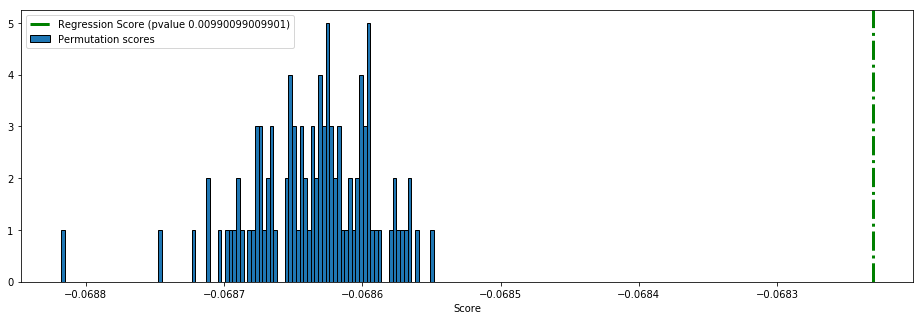

In [52]:

# #############################################################################
# View histogram of permutation scores
fig, ax = plt.subplots(figsize=(16,5))
plt.hist(permutation_scores,100, label='Permutation scores',edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '-.g', linewidth=3,
          label='Regression Score'
          ' (pvalue %s)' % pvalue)

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

As seen the model prediction is seen to have outperformed all other random permutation tests performed, its affinity to the target variable is evident from the fact that the average mean absolute score reduces when applied on random shuffled target